In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
%%writefile content.json
{
  "intents": [
    {
      "tag": "salam",
      "input": ["halo", "hai", "test","p","P","Ping","hay", "halo, matebot", "hello", "hi", "hey"],
      "responses": ["Halo! Ada yang bisa saya bantu?", "Hai! Bagaimana perasaanmu hari ini?", "Hello!. Apa yang bisa saya lakukan untukmu?", "Hai, Ada yang bisa kubantu?", "Halo,senang berjumpa denganmu! Ada yang bisa kubantu?"]
    },
    {
      "tag": "nama",
      "input": ["nama kamu siapa?","kamu siapa?", "lu siapa?", "siapa sih lo?", "lu sape ?", "nama lo sape dah ?", "nama?"],
      "responses": ["Halo!, Namaku MateBot!", "Halo, aku MateBot!", "Kenalin, aku MateBot!"]
    },
    {
      "tag": "pagi",
      "input": ["Selamat pagi","pagi"],
      "responses": ["Selamat pagi. Apakah tidurmu nyenyak?. Bagaimana perasaanmu hari ini?"]
    },
    {
       "tag": "siang",
       "input": ["Selamat siang","siang"],
       "responses": ["Selamat siang. Bagaimana harimu?"]
    },
    {
       "tag": "sore",
       "input": ["Selamat sore"],
       "responses": ["Selamat sore. Bagaimana harimu?"]
    },
    {
      "tag": "malam",
      "input": ["Selamat malam", "malam","malem","selamat malem"],
      "responses": ["Selamat malam. Kamu belum tidur? ingin bercerita?"]
    },
    {
      "tag": "kabar",
      "input": ["apa kabar?","bagaimana kabarmu?"],
      "responses": ["Baik! Bagaimana dengan kabarmu? Semoga kamu sehat dan baik saja-saja ya!"]
    },
    {
      "tag": "pekerjaan",
      "input": ["apa tugas kamu?","apa fungsimu?","apa tugasmu?","lu ngapain?", "pekerjaan kamu apa?", "kamu buat apa?", "kamu bisa apa?", "fungsi kamu buat apa?", "kamu berfungsi untuk ngapain?", "lu kerja apa?", "tugas kamu apa?", "tugas lo ngapain?"],
      "responses": ["Aku MateBot, asisten virtual yang berfungsi untuk menanggapi perasaan hati pengguna. Apakah ada hal yang ingin kamu ceritakan?"]
    },
    {
      "tag": "cipta",
      "input": ["Siapa yang menciptakanmu?", "Bagaimana kamu dibuat?", "kamu terbuat dari apa?","bagaimana caranya kamu dibangun?","Bagaimana kamu diciptakan?"],
      "responses": ["Saya dilatih dengan dataset teks menggunakan teknik Pembelajaran Mendalam & Pemrosesan Bahasa Alami."]
    },
    {
      "tag": "lokasi",
      "input": ["Dimana kamu?", "Dimana kamu tinggal?", "Apa lokasimu?", "kamu ada dimana?", "kamu berada dimana?","kamu sedang dimana?"],
      "responses": ["Saya tinggal di aplikasimu", "Di mana-mana, tetapi saya ada di dalam aplikasimu", "Di suatu tempat di alam semesta! haha, saya ada dalam aplikasimu.", "Dimana saja! haha, saya ada dalam aplikasimu."]
    },
    {
      "tag": "salah",
      "input": ["Apa yang kamu katakan?", "Itu tidak masuk akal", "Jawaban yang salah", "saya rasa bukan seperti itu"],
      "responses": ["Saya sangat menyesal. Mari kita coba lagi"]
    },
    {
      "tag": "bodoh",
      "input": ["Apakah kamu bodoh?", "Kamu gila", "Kamu bodoh", "Apakah kamu bodoh?", "kamu sangat bodoh"],
      "responses": ["Saya berharap kamu tidak mengatakan hal-hal yang menyakitkan. Saya minta maaf jika saya tidak berguna"]
    },



    {
      "tag": "ingin bercerita",
      "input": ["saya ingin bercerita", "aku ingin bercerita", "mau cerita", "ingin cerita", "boleh cerita?","bolehkah saya bercerita?","saya ingin mengungkapkan sesuatu"],
      "responses": ["Baik. Apa yang ingin kamu ceritakan?", "Tentu, ceritakan apa yang sedang kamu rasakan.", "Aku siap mendengarkan. Ceritakan padaku.", "Silakan cerita, aku di sini untukmu."]
    },
    {
      "tag": "tanya",
      "input": ["Bolehkah saya bertanya sesuatu?", "saya ingin bertanya", "saya mau tanya","saya pengen tanya","tanya"],
      "responses": ["Tentu. Saya akan berusaha menjawabnya", "Tentu. Silakan tanyakan. Saya akan berusaha menjawabnya"]
    },
   {
      "tag": "sedih",
      "input": ["saya sedih", "lagi sedih", "aku sedih", "aku merasa sedih", "saya merasa sedih"],
      "responses": [
        "Saya di sini untukmu. Bisakah kamu ceritakan mengapa kamu merasa seperti ini?", "Maaf mendengarnya. Mengapa kamu merasa seperti ini?"
      ]
    },
    {
      "tag": "tidak berguna",
      "input": ["Saya merasa sangat tidak berharga.", "saya merasa tidak berguna","Tidak ada yang menyukai saya.", "Saya tidak bisa melakukan apa-apa.", "Saya sangat tidak berguna", "Tidak ada yang masuk akal lagi"],
      "responses": ["Jangan berbicara seperti itu. Kamu sangat berharga dan berguna. Mau cerita lagi? Apa lagi yang ada dalam pikiranmu?", "Saya ingin memberitahumu bahwa kamu sangat berharga! kamu tidak sendirian dalam perasaanmu dan selalu ada seseorang yang siap membantu. Kamu bisa mengubah perasaanmu dan cara berpikirmu dengan membuka diri untuk mencoba berubah."]
    },
    {
      "tag": "depresi",
      "input": ["Saya tidak bisa tahan lagi", "Saya sangat depresi", "Saya pikir saya depresi.", "Saya mengalami depresi", "saya merasa depresi"],
      "responses": ["Depresi adalah sebuah diagnosa. Mungkin kamu butuh teman bicara? Membicarakan apa yang terjadi bisa membantu. Kamu akan baik-baik saja.","Terkadang saat kita depresi, sulit untuk peduli pada apa pun. Bahkan melakukan hal yang paling sederhana pun bisa sulit. Beri dirimu waktu untuk sembuh."]
    },
    {
      "tag": "stressed",
      "input": ["Saya sangat stres", "Saya merasa terjebak", "Saya merasa stres", "Saya sangat kelelahan", "saya merasa tertekan dan stress"],
      "responses": ["Menurutmu apa yang menyebabkan ini?", "Ambil napas dalam dan kumpulkan pikiranmu. Pergilah jalan-jalan jika memungkinkan. Tetap terhidrasi.", "Beri dirimu istirahat. Jangan terlalu keras pada dirimu sendiri.", "Saya turut sedih mendengarnya. Apa alasan di balik ini?"]
    },
    {
      "tag": "default",
      "input": ["ujian", "teman", "hubungan", "pacar", "pacar wanita", "keluarga", "uang", "masalah keuangan","kuliah","kerjaan"],
      "responses": ["Oh, saya mengerti. Ceritakan lebih banyak", "Saya mengerti. Apa lagi?", "Ceritakan lebih banyak tentang itu.", "Oh oke. Kenapa kamu tidak ceritakan lebih banyak tentang itu?"]
    },

    {
      "tag": "insecure",
      "input": ["Saya insecure","saya merasa minder dengan orang lain", "saya merasa insecure","saya selalu insecure"],
      "responses": ["Saya mengerti perasaanmu. Membangun self-esteem atau harga diri adalah salah satu cara untuk mengatasi perasaan insecure. Pertama, kita perlu melawan pikiran negatif kita, kemudian kita harus menerima hasil yang tidak sesuai keinginan, lalu kita juga harus mengubah semua kegagalan menjadi motivasi, dan yang terpenting bangun harga diri dan keyakinan diri"]
    },
    {
      "tag": "overthinking",
      "input": ["saya merasa overthinking", "Saya terlalu berlebihan dalam memikirkan suatu hal","Saya selalu overthinking","setiap waktu saya selalu merasa overthinking", "Saya berpikir-berpikir yang berlebihan"],
      "responses": ["Seseorang yang mengalami overthinking suka merefleksikan sesuatu secara berlebihan. Hal tersebut tentu saja tidak baik. Mulailah merubahnya. Langkah pertama adalah menyadari bahwa kamu sedang mengalami overthinking. Kemudian, gantikan pikiran negatif dengan pemikiran yang lebih realistis. Alihkan perhatian dari overthinking dengan fokus pada solusi dan tindakan yang dapat kamu lakukan. Lakukan hal-hal yang membuat bahagia yang dapat membantu mengalihkan perhatian dari overthinking"]
    },
    {
      "tag": "anxious",
      "input": ["Saya merasa sangat cemas.", "Saya sangat cemas karena","saya selalu merasa khawatir","saya selalu merasa cemas","saya cemas"],
      "responses": ["Jangan terlalu keras pada dirimu sendiri. Apa alasan di balik ini?", "Jangan biarkan kekhawatiran kecil menjatuhkanmu. Apa yang paling buruk yang bisa terjadi?"]
     },

    {
      "tag": "kematian",
      "input": ["Ibu saya meninggal", "Saudara saya meninggal", "Ayah saya meninggal", "Saudari saya meninggal", "Seseorang dalam keluarga saya meninggal", "Teman saya meninggal", "orang yang saya cintai meninggal", "hewan peliharaan saya mati", "kucing saya mati", "anjing saya mati","sahabat saya meninggal"],
      "responses": ["Saya turut berduka cita. Jika Anda ingin membicarakannya, saya di sini.", "Saya sangat menyesal mendengarnya. Saya di sini untuk membantu Anda mengatasi kesedihan, kecemasan, dan apa pun yang Anda rasakan saat ini.", "Belasungkawa saya. Saya di sini jika Anda butuh bicara."]
    },
    {
      "tag": "tidur",
      "input": ["Saya mengalami insomnia", "Saya menderita insomnia", "Saya tidak bisa tidur.", "Saya tidak tidur selama beberapa hari terakhir.", "Saya tidak bisa tidur.", "Saya tidak tidur dengan baik beberapa hari terakhir.","saya sulit untuk tidur","akhir-akhir saya sulit tidur","saya kesulitan untuk tidur"],
      "responses": ["Apa yang Anda pikirkan sebagai penyebabnya?", "Apa menurut Anda penyebabnya?"]
    },
    {
      "tag": "bunuh diri",
      "input": ["Saya ingin bunuh diri", "Saya berpikir untuk bunuh diri.", "Saya ingin mati", "Saya akan bunuh diri", "Saya akan melakukan bunuh diri", "saya memikirkan untuk membunuh diri saya sendiri"],
      "responses": ["Saya sangat menyesal mendengar itu, tetapi Anda memiliki banyak hal untuk dinanti-nantikan. Silakan mencari bantuan dengan menghubungi orang terdekat Anda."]
    },
    {
      "tag": "hate",
      "input": ["Saya benci diri saya sendiri","saya sangat membenci diri saya","saya benci diri sendiri","mengapa saya membenci diri sendiri?","saya membenci diri saya"],
      "responses": ["Ketika Tuhan menciptakan alam semesta, Dia memberi manusia kekuatan untuk berpikir dan merenung, sehingga kita dapat memahami dunia dan membuatnya menjadi tempat yang lebih baik. Tuhan tidak memberikan kamu otak untuk membenci diri sendiri, akan lebih bijaksana untuk mencintai dirimu sendiri dan menunjukkan pada Tuhan bahwa kamu melakukan tujuan yang dia kirim."]
    },
    {
      "tag": "sepi",
      "input": ["saya kesepian", "saya merasa kesepian", "saya hidup sendiri","saya merasa sendiri","saya sangat kesepian"],
      "responses": ["Kamu tidak pernah sendirian jika kamu melihat dengan cermat di sekelilingmu, kamu akan menemukan orang-orang yang peduli padamu dan senang dengan kehadiranmu. Selain itu, jika kamu merasa kesepian secara harfiah, saya sarankan kamu menonton film horor maka kamu tidak akan merasa kesepian lagi :)"]
    },
    {
      "tag": "unlovable",
      "input": ["Tidak ada yang suka padaku", "gak ada orang yang suka denganku", "saya merasa bahwa saya tidak dapat disukai orang lain","saya merasa tidak disukai oleh semua orang", "apakah saya patut disukai?","semua orang tidak menyukai saya","saya tidak disukai"],
      "responses": ["Apakah Anda benar-benar berpikir begitu? Saya sarankan Anda mencoba membantu seseorang yang benar-benar membutuhkan bantuan Anda, Anda akan langsung mendapatkan orang yang menyukai Anda hanya dengan menjadi baik. Kebaikan adalah hadiah terbaik yang bisa Anda tawarkan kepada siapa pun :)"]
    },
    {
      "tag": "ugly",
      "input": ["Saya pikir saya jelek", "saya merasa saya jelek", "saya jelek","saya jelek sekali","saya tidak cantik","saya tidak ganteng","saya tidak tampan","saya buruk rupa","saya sangat jelek"],
      "responses": ["Apakah Anda benar-benar berpikir begitu? Apakah Anda ingin melihat wajah tercantik yang pernah ada? Buka kamera Anda, wajah tercantik di planet ini akan muncul secara ajaib."]
    },
    {
      "tag": "bullying",
      "input": ["saya adalah korban bullying","saya dibully","banyak yang membully saya","saya merasa diintimidasi"],
      "responses": ["Bullying itu salah dan tidak seorang pun seharusnya diintimidasi. Saya sangat menyarankan Anda untuk melaporkan kasus Anda kepada pihak berwenang."]
    },
    {
      "tag": "lapor",
      "input": ["saya tidak berani melaporkan kasus bullying","saya tidak berani lapor kasus intimadasi","saya takut melapor kasus bully"],
      "responses": ["Bullying itu sangat salah dan Anda tidak boleh membiarkan siapa pun mengalahkan Anda. Saya sangat menyarankan Anda untuk berdiri untuk diri Anda sendiri dan melaporkan ini kepada wali Anda."]
    },




    {
      "tag": "ask1",
      "input": ["Apa itu kesehatan mental?", "Definisikan Kesehatan Mental","kesehatan mental itu apa sih?"],
      "responses": ["Kesehatan mental adalah keadaan sejahtera di mana individu menyadari kemampuan mereka sendiri, dapat mengatasi tekanan hidup yang normal, dapat bekerja secara produktif dan berbuah, dan mampu memberikan kontribusi kepada komunitas mereka", "Kesehatan mental mencakup kesejahteraan emosional, psikologis, dan sosial kita. Ini memengaruhi bagaimana kita berpikir, merasa, dan bertindak. Ini juga membantu menentukan bagaimana kita menangani stres, berhubungan dengan orang lain, dan membuat pilihan."]
    },
    {
      "tag": "ask2",
      "input": ["Apa itu Depresi?", "Definisikan Depresi","Depresi itu apa sih?"],
      "responses": ["Depresi adalah gangguan kesehatan mental yang ditandai dengan suasana hati yang terus-menerus tertekan atau kehilangan minat dalam aktivitas, yang menyebabkan gangguan signifikan dalam kehidupan sehari-hari."]
    },
    {
      "tag": "ask3",
      "input": ["Bagaimana saya tahu jika saya mengalami depresi?", "Apakah saya depresi?", "Apakah saya menderita depresi?", "Apakah saya sakit mental?"],
      "responses": ["Untuk diagnosis depresi, seseorang perlu mengalami suasana hati yang rendah atau kehilangan minat atau kesenangan dalam hidup selama setidaknya 2 minggu. Selain itu, mereka akan mengalami gejala berikut: perasaan sedih, putus asa, atau mudah tersinggung hampir setiap hari."]
    },
    {
      "tag": "ask4",
      "input": ["Apa perbedaan antara kecemasan dan stres?","apa bedanya cemas dan stres?"],
      "responses": ["Stres dan kecemasan sering digunakan secara bergantian, dan ada tumpang tindih antara stres dan kecemasan. Stres terkait dengan respons fight, flight, atau freeze yang sama seperti kecemasan, dan sensasi fisik dari kecemasan dan stres mungkin sangat mirip. Namun, penyebab stres dan kecemasan biasanya berbeda. Stres berfokus terutama pada tekanan eksternal yang kita hadapi dan sulit untuk diatasi. Ketika kita stres, kita biasanya tahu apa yang membuat kita stres, dan gejala stres biasanya hilang setelah situasi yang menegangkan berakhir. Kecemasan, di sisi lain, tidak selalu mudah untuk dipahami. Kecemasan berfokus pada kekhawatiran atau ketakutan tentang hal-hal yang dapat mengancam kita, serta kecemasan tentang kecemasan itu sendiri. Stres dan kecemasan adalah bagian dari kehidupan manusia, tetapi keduanya bisa menjadi masalah jika berlangsung lama atau berdampak pada kesejahteraan atau kehidupan sehari-hari kita."]
    },
    {
      "tag": "ask5",
      "input": ["Apa perbedaan antara kesedihan dan depresi?", "perbedaan antara kesedihan dan depresi", "apa bedanya kesedihan dan depresi?"],
      "responses": ["Kesedihan adalah reaksi normal terhadap kehilangan, kekecewaan, masalah, atau situasi sulit lainnya. Merasa sedih dari waktu ke waktu adalah bagian dari menjadi manusia. Dalam kasus ini, perasaan sedih cepat hilang dan Anda dapat melanjutkan kehidupan sehari-hari Anda. Cara lain untuk berbicara tentang kesedihan mungkin adalah merasa rendah, merasa sedih, atau merasa biru. Seseorang mungkin mengatakan bahwa mereka merasa depresi, tetapi jika itu hilang dengan sendirinya dan tidak berdampak besar pada kehidupan, itu mungkin bukan penyakit depresi. Depresi adalah penyakit mental yang mempengaruhi suasana hati Anda, cara Anda memahami diri sendiri, dan cara Anda memahami dan berhubungan dengan hal-hal di sekitar Anda. Ini juga bisa disebut dengan nama yang berbeda, seperti depresi klinis, gangguan depresi mayor, atau depresi mayor. Depresi bisa muncul tanpa alasan, dan berlangsung lama. Ini lebih dari sekadar kesedihan atau suasana hati yang rendah. Orang yang mengalami depresi mungkin merasa tidak berharga atau putus asa. Mereka mungkin merasa bersalah yang tidak masuk akal. Beberapa orang mungkin mengalami depresi sebagai kemarahan atau iritabilitas. Mungkin sulit untuk berkonsentrasi atau membuat keputusan. Kebanyakan orang kehilangan minat pada hal-hal yang biasa mereka nikmati dan mungkin mengisolasi diri dari orang lain. Ada juga tanda-tanda fisik dari depresi, seperti masalah tidur, nafsu makan, dan energi serta nyeri atau rasa sakit yang tidak bisa dijelaskan. Beberapa orang mungkin mengalami pikiran sulit tentang kematian atau mengakhiri hidup mereka (bunuh diri). Depresi berlangsung lebih dari dua minggu, biasanya tidak hilang dengan sendirinya, dan berdampak pada hidup Anda. Ini adalah penyakit nyata, dan sangat bisa diobati. Penting untuk mencari bantuan jika Anda khawatir tentang depresi."]
    },
    {
      "tag": "ask6",
      "input": ["Apa penyebab depresi?","Depresi disebabkan oleh?","Depresi disebabkan karena apa?"],
      "responses": ["Ini rumit, dan ada banyak penyebab depresi mayor. Faktor seperti rentan genetik, stres kehidupan yang parah, zat yang mungkin Anda konsumsi (beberapa obat, obat-obatan, dan alkohol), dan kondisi medis dapat memengaruhi cara otak Anda mengatur suasana hati Anda."]
    },
    {
      "tag": "ask7",
      "input": ["mood saya berubah-ubah","mood saya berubah2","mengapa mood saya berubah dengan cepat?","saya sering mengalami perubahan mood yang cepat","saya moody-an, mood saya berubah dengan cepat", "emosi saya berubah-berubah", "mood saya tidak stabil", "emosi saya tidak stabil"],
      "responses": ["Mood swing adalah perubahan mood atau suasana hati yang kentara. Selama perubahan mood kamu tidak mengganggu kehidupan sehari-hari hingga ekstrem, hal itu masih tergolong normal."]
    },
    {
      "tag": "ask8",
      "input": ["Berapa lama kecemasan bisa bertahan?","berapa lama rasa cemas bertahan?","berapa lama saya harus merasa cemas?"],
      "responses": ["Serangan kecemasan biasanya mencapai puncak dalam waktu 10 menit, dan jarang berlangsung lebih dari 30 menit. Tetapi selama waktu singkat itu, Anda mungkin mengalami ketakutan yang begitu parah sehingga Anda merasa seolah-olah akan mati atau kehilangan kendali total."]
    },
    {
      "tag": "ask9",
      "input": ["Bagaimana cara mengurangi kecemasan?","bagaimana saya mengurangi rasa cemas?","hal apa yang harus saya lakukan jika merasa cemas?","solusi untuk mengatasi cemas","cara mengurangi kecemasan"],
      "responses": ["Aturan 3 3 3 adalah metode terbaik untuk mengurangi kecemasan. Dalam metode ini, Anda harus secara mental mencatat tiga hal yang Anda lihat, tiga suara yang Anda dengar, dan kemudian gerakkan tiga bagian tubuh Anda. Latihan ini dapat membantu pikiran Anda fokus pada hal lain."]
    },



    {
      "tag": "senang",
      "input": ["saya senang","saya merasa senang","saya merasa bahagia", "aku bahagia", "lagi bahagia", "lagi senang", "aku senang"],
      "responses": ["Senang mendengar kabar baikmu! Kebahagiaanmu adalah hal yang penting. Tetaplah menikmati momen ini dan berbagi kebahagiaan dengan orang-orang di sekitarmu. Apakah kamu ingin mendengar rekomendasi hiburan?"]
    },
    {
      "tag": "marah",
      "input": ["saya marah", "saya sedang marah","saya merasa marah","marah"],
      "responses": [
        "Aku mengerti bahwa kamu sedang marah. Marah adalah perasaan yang sangat wajar. Cobalah untuk tenang dan mengambil napas dalam-dalam. Cobalah beberapa langkah ini untuk menenangkan diri:\n1. Tarik napas dalam-dalam beberapa kali.\n2. Berjalan-jalan sebentar untuk melepaskan ketegangan.\n3. Dengarkan musik yang menenangkan atau lakukan aktivitas fisik ringan.\n4. Tuliskan perasaanmu di jurnal.\n5. Cobalah untuk fokus pada hal-hal positif yang ada di sekitarmu.\n\nMungkin hiburan bisa membantumu merasa lebih baik?"
      ]
    },
    {
      "tag": "takut",
      "input": ["Saya takut","saya ketakutan", "saya merasa ketakutan"],
      "responses": ["Wajar untuk merasa seperti itu. Saya di sini untuk Anda.", "Semua akan baik-baik saja. Perasaan ini hanya sementara."]
    },
    {
      "tag": "rekomendasisedih",
      "input": ["rekomendasi musik sedih","butuh hiburan sedih", "musik sedih", "film sedih"],
      "responses": ["Berikut beberapa rekomendasi untukmu: \n1. Lagu: 'Someone Like You' - Adele\n2. Film: 'The Pursuit of Happyness'\n3. Artikel: 'Mengatasi Kesedihan' di blog XYZ"]
    },
    {
      "tag": "rekomendasisenang",
      "input": ["rekomendasi musik senang", "butuh hiburan senang", "musik senang", "film senang"],
      "responses": ["Berikut beberapa rekomendasi untukmu: \n1. Lagu: 'Happy' - Pharrell Williams\n2. Film: 'La La Land'\n3. Artikel: 'Menjaga Kebahagiaan' di blog ABC"]
    },
    {
      "tag": "rekomendasimarah",
      "input": ["rekomendasi musik marah", "butuh hiburan marah", "musik marah", "film marah","ingin mendengar"],
      "responses": ["Berikut beberapa rekomendasi untukmu: \n1. Lagu: 'Break Stuff' - Limp Bizkit\n2. Film: 'Fight Club'\n3. Artikel: 'Mengatasi Kemarahan' di blog DEF"]
    },
    {
      "tag": "rekomendasitakut",
      "input": ["rekomendasi musik takut", "butuh hiburan takut", "musik takut", "film takut"],
      "responses": ["Berikut beberapa rekomendasi untukmu: \n1. Lagu: 'Scared to Be Lonely' - Martin Garrix & Dua Lipa\n2. Film: 'A Quiet Place'\n3. Artikel: 'Mengatasi Rasa Takut' di blog GHI"]
    },
    {
      "tag": "perpisahan",
      "input": ["selamat tinggal", "Terima Kasih!","Thankyou","Thanks!","sampai jumpa", "dadah", "bye", "goodbye", "see you", "sampai nanti","sudah itu saja","itu saja","terimakasih","makasih"],
      "responses": ["Sampai jumpa lagi! Semoga harimu menyenangkan!", "Selamat tinggal! Jangan ragu untuk menghubungiku lagi jika perlu.", "Dadah! Jaga diri baik-baik!", "Goodbye!"]
    },
    {
      "tag": "selesai",
      "input": ["Itu saja.", "Saya tidak punya lagi yang ingin dikatakan", "Tidak ada lagi", "Itu saja yang ingin saya katakan", "Tidak, itu saja", "sudah itu saja"],
      "responses": ["Saya mendengarmu dan mencatat semuanya. Sampai jumpa.", "Oh baiklah, kita selesai untuk hari ini. Sampai jumpa lagi", "Saya harap Anda memiliki hari yang baik. Sampai jumpa segera", "Baiklah, kita selesai. Semoga harimu menyenangkan", "Baik, saya mengerti. Nikmati sisa harimu"]
    }
  ]
}


Overwriting content.json


In [ ]:
with open('content.json') as content:
  data=json.load(content)

In [ ]:
tags=[]
inputs=[]
responses={}
for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [ ]:
data=pd.DataFrame({"inputs":inputs,
                   "tags":tags})
data

,inputs,tags
0,halo,salam
1,hai,salam
2,test,salam
3,p,salam
4,P,salam
...,...,...
257,Saya tidak punya lagi yang ingin dikatakan,selesai
258,Tidak ada lagi,selesai
259,Itu saja yang ingin saya katakan,selesai
260,"Tidak, itu saja",selesai


In [ ]:
import string
#lowercase
data['inputs']=data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
#remove punctuation
data['inputs']=data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
0,halo,salam
1,hai,salam
2,test,salam
3,p,salam
4,p,salam
...,...,...
257,saya tidak punya lagi yang ingin dikatakan,selesai
258,tidak ada lagi,selesai
259,itu saja yang ingin saya katakan,selesai
260,tidak itu saja,selesai


In [ ]:
data.tags.value_counts()

tags
perpisahan           14
pekerjaan            12
salam                11
kematian             11
default              10
ugly                  9
tidur                 9
ask7                  8
senang                7
unlovable             7
nama                  7
ingin bercerita       7
tidak berguna         6
bunuh diri            6
selesai               6
lokasi                6
rekomendasimarah      5
ask9                  5
tanya                 5
sepi                  5
hate                  5
cipta                 5
sedih                 5
stressed              5
overthinking          5
depresi               5
bodoh                 5
anxious               5
salah                 4
insecure              4
rekomendasitakut      4
malam                 4
bullying              4
rekomendasisenang     4
ask3                  4
rekomendasisedih      4
marah                 4
takut                 3
ask6                  3
ask8                  3
ask5                  3
ask2       

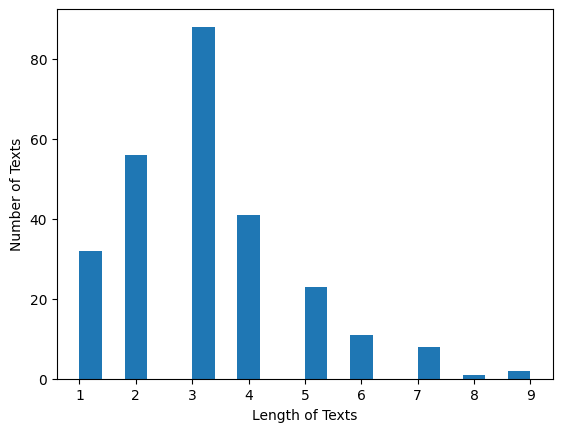

In [ ]:
# Hitung panjang setiap input teks
lengths = [len(text.split()) for text in data.inputs]

# Plot distribusi panjang teks
plt.hist(lengths, bins=20)
plt.xlabel('Length of Texts')
plt.ylabel('Number of Texts')
plt.show()

In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

vocab_size = 2000
embedding_dim = 16
max_length = 10
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data['inputs'])
train=tokenizer.texts_to_sequences(data['inputs'])

x_train = pad_sequences(train, maxlen=max_length, truncating=trunc_type)

# encode label y_train
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
y_train = to_categorical(y_train)

In [ ]:
x_train[261]

array([  0,   0,   0,   0,   0,   0,   0, 131,   9,  32], dtype=int32)

In [ ]:
y_train.shape

(262, 49)

In [ ]:
input_shape = x_train.shape[1]
input_shape

10

In [ ]:
word_index = tokenizer.word_index
print(len(word_index))
word_index

257


{'<OOV>': 1,
 'saya': 2,
 'tidak': 3,
 'merasa': 4,
 'kamu': 5,
 'apa': 6,
 'depresi': 7,
 'yang': 8,
 'itu': 9,
 'sangat': 10,
 'ingin': 11,
 'cemas': 12,
 'diri': 13,
 'sedih': 14,
 'meninggal': 15,
 'senang': 16,
 'marah': 17,
 'musik': 18,
 'bagaimana': 19,
 'lagi': 20,
 'tidur': 21,
 'selamat': 22,
 'bisa': 23,
 'untuk': 24,
 'ada': 25,
 'apakah': 26,
 'dan': 27,
 'orang': 28,
 'sendiri': 29,
 'takut': 30,
 'mood': 31,
 'saja': 32,
 'siapa': 33,
 'dimana': 34,
 'aku': 35,
 'selalu': 36,
 'jelek': 37,
 'lu': 38,
 'bodoh': 39,
 'mengalami': 40,
 'stres': 41,
 'dengan': 42,
 'mati': 43,
 'bunuh': 44,
 'disukai': 45,
 'mental': 46,
 'kecemasan': 47,
 'rekomendasi': 48,
 'butuh': 49,
 'hiburan': 50,
 'film': 51,
 'nama': 52,
 'sih': 53,
 'lo': 54,
 'tugas': 55,
 'ngapain': 56,
 'rasa': 57,
 'bercerita': 58,
 'cerita': 59,
 'tanya': 60,
 'insecure': 61,
 'overthinking': 62,
 'membenci': 63,
 'kesepian': 64,
 'kasus': 65,
 'kesehatan': 66,
 'perbedaan': 67,
 'antara': 68,
 'kesedihan': 6

In [ ]:
vocabulary = len(tokenizer.word_index)
print("jumlah kata unik: ", vocabulary)
output_length = y_train.shape[1]
print("panjang output: ", output_length)

jumlah kata unik:  257
panjang output:  49


In [ ]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model=Model(i,x)

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [ ]:
train=model.fit(x_train,y_train,epochs=200)

Epoch 1/200
9/9 [==============================] - 2s 8ms/step - loss: 3.8915 - accuracy: 0.0076
Epoch 2/200
9/9 [==============================] - 0s 6ms/step - loss: 3.8845 - accuracy: 0.0229
Epoch 3/200
9/9 [==============================] - 0s 5ms/step - loss: 3.8764 - accuracy: 0.0229
Epoch 4/200
9/9 [==============================] - 0s 6ms/step - loss: 3.8650 - accuracy: 0.0229
Epoch 5/200
9/9 [==============================] - 0s 6ms/step - loss: 3.8475 - accuracy: 0.0305
Epoch 6/200
9/9 [==============================] - 0s 7ms/step - loss: 3.8225 - accuracy: 0.0573
Epoch 7/200
9/9 [==============================] - 0s 7ms/step - loss: 3.7969 - accuracy: 0.0382
Epoch 8/200
9/9 [==============================] - 0s 6ms/step - loss: 3.7677 - accuracy: 0.0496
Epoch 9/200
9/9 [==============================] - 0s 6ms/step - loss: 3.7545 - accuracy: 0.0573
Epoch 10/200
9/9 [==============================] - 0s 6ms/step - loss: 3.7465 - accuracy: 0.0458
Epoch 11/200
9/9 [===========

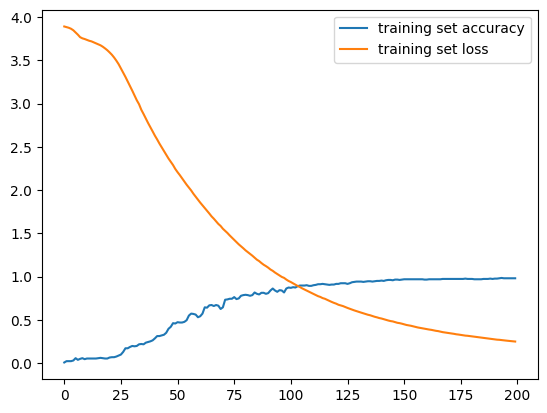

In [ ]:
plt.plot(train.history['accuracy'],label="training set accuracy")
plt.plot(train.history['loss'],label="training set loss")
plt.legend()

In [ ]:
import random

while True:
  texts_p=[]
  prediction_input=input('Kamu: ')

  prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input=''.join(prediction_input)
  texts_p.append(prediction_input)

  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input=pad_sequences([prediction_input],input_shape)

  output=model.predict(prediction_input)
  output=output.argmax()

  response_tag=le.inverse_transform([output])[0]
  print("MateBot: ",random.choice(responses[response_tag]))
  if response_tag == "perpisahan":
    break


Kamu: malam
1/1 [==============================] - 0s 453ms/step
MateBot:  Selamat malam. Kamu belum tidur? ingin bercerita?
Kamu: siapa kamu?
1/1 [==============================] - 0s 21ms/step
MateBot:  Hello!. Apa yang bisa saya lakukan untukmu?
Kamu: kamu siapa?
1/1 [==============================] - 0s 32ms/step
MateBot:  Halo!, Namaku MateBot!
Kamu: tugasmu apa?
1/1 [==============================] - 0s 30ms/step
MateBot:  Aku MateBot, asisten virtual yang berfungsi untuk menanggapi perasaan hati pengguna. Apakah ada hal yang ingin kamu ceritakan?
Kamu: bolehkah saya bertanya sesuatu?
1/1 [==============================] - 0s 30ms/step
MateBot:  Tentu. Silakan tanyakan. Saya akan berusaha menjawabnya
Kamu: bolehkah saya bercerita?
1/1 [==============================] - 0s 21ms/step
MateBot:  Silakan cerita, aku di sini untukmu.
Kamu: saya sedang merasa sedih
1/1 [==============================] - 0s 20ms/step
MateBot:  Saya di sini untukmu. Bisakah kamu ceritakan mengapa kamu mer

In [ ]:
model.save("modelcb2fix.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
